In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import *
from datetime import datetime
from sklearn.metrics import *
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

In [4]:
# !pip install xgboost
# !pip install imblearn

In [5]:
df = pd.read_csv("Pendapatan.csv",index_col=0)
df.head(2)
df = df.sort_index()

df.columns
df.columns = ["umur","kelas pekerja","berat akhir","pendidikan","tahun pendidikan","status kawin","pekerjaan","sex","keuntungan","kerugian","JPM","gaji"]

### Handling Categorical data

In [6]:
df["kelas pekerja"] = df["kelas pekerja"].replace("?","jc_unknown")
df["pekerjaan"] = df["pekerjaan"].replace("?","job_unknown")

In [7]:
df.isna().sum()

umur                0
kelas pekerja       0
berat akhir         0
pendidikan          0
tahun pendidikan    0
status kawin        0
pekerjaan           0
sex                 0
keuntungan          0
kerugian            0
JPM                 0
gaji                0
dtype: int64

#### Education

In [8]:
edu_map = {
    "SD":1, "1st-4th":1, "5th-6th":2, "7th-8th":3, "9th":4,
    "SMA":5, "10th":5, "11th":6, "12th":7,
    "Pendidikan Tinggi":8, "D3":8, "D4":9,"Sarjana":9,
    "Master":10, "Doktor":11, "Sekolah Professional":12 
}
df["pendidikan"] = df["pendidikan"].map(edu_map)

#### Marriage

In [9]:
mar_map = {
    "Belum Pernah Menikah":0,
    "Menikah":1, "Menikah LDR":1,
    "Cerai":2, "Berpisah":2, "Janda":2
}
df["status kawin"] = df["status kawin"].map(mar_map)

#### Sex

In [10]:
sex_map = {
    "Perempuan":0,
    "Laki2":1
}
df["sex"] = df["sex"].map(sex_map)

### Ordinal Data

#### Occupation

In [11]:
job = pd.get_dummies(df[["kelas pekerja","pekerjaan"]])
df.drop(["pekerjaan","kelas pekerja"], axis=1, inplace=True)
df= pd.concat([df,job],axis=1)
df.head(1)

,umur,berat akhir,pendidikan,tahun pendidikan,status kawin,sex,keuntungan,kerugian,JPM,gaji,...,pekerjaan_Penjaga,pekerjaan_Perbaikan Kerajinan,pekerjaan_Petani,pekerjaan_Sales,pekerjaan_Servis Lainnya,pekerjaan_Spesialis,pekerjaan_Supir,pekerjaan_Tech-support,pekerjaan_Tentara,pekerjaan_job_unknown
id,,,,,,,,,,,,,,,,,,,,,
0,39,77516,9,13,0,1,30436000.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
x = df.drop(["gaji","keuntungan","kerugian","berat akhir","tahun pendidikan"],axis=1)
y = df["gaji"]

In [13]:
print(x.info())
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38393 entries, 0 to 47991
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   umur                                         38393 non-null  int64  
 1   pendidikan                                   38393 non-null  int64  
 2   status kawin                                 38393 non-null  int64  
 3   sex                                          38393 non-null  int64  
 4   JPM                                          38393 non-null  float64
 5   kelas pekerja_Pekerja Bebas Bukan Perusahan  38393 non-null  uint8  
 6   kelas pekerja_Pekerja Bebas Perusahaan       38393 non-null  uint8  
 7   kelas pekerja_Pemerintah Lokal               38393 non-null  uint8  
 8   kelas pekerja_Pemerintah Negara              38393 non-null  uint8  
 9   kelas pekerja_Pemerintah Provinsi            38393 non-null  uint8  
 10

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_std = scaler.fit_transform(x)

### Build ML

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
lr = LogisticRegression()
dt = DecisionTreeClassifier()
sv = SVC()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
kn = KNeighborsClassifier()
nb = GaussianNB()
sm = RandomOverSampler()

model = [lr,dt,sv,rf,kn,gb,nb]
model_name = {lr:"Logistic Regression", rf:"Random Forest", kn:"KNN",sv:"SVC",dt:"Decision Tree",gb:"Gradient Boosting",nb:"Naive Bayes"}

x_train, x_test, y_train, y_test = train_test_split(x_std, y, stratify=y, random_state=101)
x_sm,y_sm = sm.fit_resample(x_train, y_train)
x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(x_sm, y_sm, stratify=y_sm, random_state=101)

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
from sklearn.metrics import auc

In [18]:
def evaluasi(model):
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))
    print("AUC SCORE:",roc_auc_score(y_test,y_pred))

### Logistic Regression

In [21]:
param = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter" : [1, 10, 100, 1000, 10000],
    "C": np.logspace(-4,4,20),
    "dual" : [False], "fit_intercept" : [True],
    "intercept_scaling" : [1],
    "multi_class": ['auto'], "tol": [0.0001],
}

lr = LogisticRegression()
lr_best = RandomizedSearchCV(estimator= lr, param_distributions= param, cv= 5, verbose=1, random_state=101, n_iter=20)
lr_best.fit(x_train_sm, y_train_sm)
print(lr_best.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


{'tol': 0.0001, 'solver': 'newton-cg', 'penalty': 'none', 'multi_class': 'auto', 'max_iter': 1000, 'intercept_scaling': 1, 'fit_intercept': True, 'dual': False, 'C': 0.0001}


In [23]:
lr.fit(x_train_sm, y_train_sm)
evaluasi(lr)

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      7300
           1       0.47      0.76      0.58      2299

    accuracy                           0.74      9599
   macro avg       0.69      0.75      0.70      9599
weighted avg       0.80      0.74      0.76      9599

AUC SCORE: 0.7471876098601536


In [24]:
evaluasi(lr_best.best_estimator_)

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      7300
           1       0.47      0.76      0.58      2299

    accuracy                           0.74      9599
   macro avg       0.69      0.75      0.70      9599
weighted avg       0.80      0.74      0.76      9599

AUC SCORE: 0.7472561030108386


### KNN

In [25]:
param = {
    "n_neighbors": np.arange(1,31),
    "algorithm": ["auto"],
    "leaf_size" : np.arange(1,51),
    "weights" : ["uniform","distance"]
}

kn = KNeighborsClassifier()
kn_best = RandomizedSearchCV(estimator= kn, param_distributions= param, cv= 5, n_iter=20, verbose=1)
kn_best.fit(x_train_sm, y_train_sm)
print(kn_best.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 14.9min finished


{'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 27, 'algorithm': 'auto'}


In [26]:
kn.fit(x_train_sm, y_train_sm)
evaluasi(kn)

              precision    recall  f1-score   support

           0       0.92      0.75      0.83      7300
           1       0.50      0.79      0.61      2299

    accuracy                           0.76      9599
   macro avg       0.71      0.77      0.72      9599
weighted avg       0.82      0.76      0.77      9599

AUC SCORE: 0.768375440185429


In [27]:
evaluasi(kn_best.best_estimator_)

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      7300
           1       0.51      0.76      0.61      2299

    accuracy                           0.77      9599
   macro avg       0.71      0.77      0.72      9599
weighted avg       0.81      0.77      0.78      9599

AUC SCORE: 0.7651893020789267


### Random Forest

In [29]:
param = {'n_estimators':np.arange(200,2000,200), 
             "max_depth":np.arange(10,110,10), 'max_features':['auto','sqrt'],
         'class_weight':['balanced','balanced_subsample'],
             "min_samples_split":[2, 5, 10],"min_samples_leaf":[1, 2, 4]}
rf = RandomForestClassifier()
rf_best = RandomizedSearchCV(rf, param,cv=5 , n_iter=10, random_state=20,verbose=1)
rf_best.fit(x_train_sm, y_train_sm)
print(rf_best.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 18.3min finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'class_weight': 'balanced', 'bootstrap': 'True'}


In [30]:
rf.fit(x_train_sm, y_train_sm)
evaluasi(rf)

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      7300
           1       0.55      0.68      0.61      2299

    accuracy                           0.79      9599
   macro avg       0.72      0.75      0.73      9599
weighted avg       0.81      0.79      0.80      9599

AUC SCORE: 0.7510552235337581


In [31]:
evaluasi(rf_best.best_estimator_)

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      7300
           1       0.55      0.68      0.61      2299

    accuracy                           0.79      9599
   macro avg       0.72      0.75      0.73      9599
weighted avg       0.81      0.79      0.80      9599

AUC SCORE: 0.7539510329088883


### XGBOOST

In [32]:
param =             {"learning_rate"    : [0.05, 0.15, 0.20, 0.30] ,
                     "max_depth"        : [ 3, 5, 8, 10, 15],
                     "min_child_weight" : [ 1, 5, 7 ],
                     "gamma"            : [ 0.0, 0.2, 0.4],
                     "colsample_bytree" : [ 0.3, 0.5 , 0.7 ] }

gb = xgb.XGBClassifier()
gb_best = RandomizedSearchCV(gb, param,cv=5 , n_iter=10, random_state=20,verbose=1)
gb_best.fit(x_train_sm, y_train_sm)
print(gb_best.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.1min finished


{'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.7}


In [33]:
gb.fit(x_train_sm, y_train_sm)
evaluasi(gb)

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7300
           1       0.55      0.83      0.66      2299

    accuracy                           0.80      9599
   macro avg       0.75      0.81      0.76      9599
weighted avg       0.84      0.80      0.81      9599

AUC SCORE: 0.8098380475132131


In [34]:
evaluasi(gb_best)

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      7300
           1       0.56      0.80      0.66      2299

    accuracy                           0.80      9599
   macro avg       0.74      0.80      0.76      9599
weighted avg       0.84      0.80      0.81      9599

AUC SCORE: 0.8019018691867221


## Evaluasi

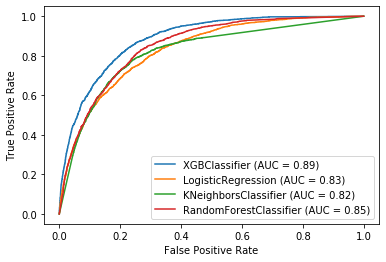

In [35]:
disp = plot_roc_curve(gb_best.best_estimator_,x_test,y_test)
plot_roc_curve(lr_best.best_estimator_, x_test, y_test, ax=disp.ax_)
plot_roc_curve(kn_best.best_estimator_, x_test, y_test, ax=disp.ax_)
plot_roc_curve(rf_best.best_estimator_, x_test, y_test, ax=disp.ax_)

In [36]:
f1_score

<function sklearn.metrics._classification.f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [37]:
base_model = [gb, lr, kn, rf]
best_model = [gb_best.best_estimator_, lr_best.best_estimator_, kn_best.best_estimator_, rf_best.best_estimator_]
name = ["Xgboost", "Logistic Regression", "KNN", "Random Forest"]
base_acc_score, base_f1_score, best_acc_score, best_f1_score = [], [], [], []

for i,v in enumerate(name):
    base_acc_score.append( accuracy_score(y_test, base_model[i].predict(x_test)) )
    base_f1_score.append( f1_score(y_test, base_model[i].predict(x_test)) )
    best_acc_score.append( accuracy_score(y_test, best_model[i].predict(x_test)) )
    best_f1_score.append( f1_score(y_test, best_model[i].predict(x_test)) )
    
pd.DataFrame({
    "name":name,
    "base acc":base_acc_score,
    "base f1":base_f1_score,
    "best_acc":best_acc_score,
    "best_f1":best_f1_score
})

,name,base acc,base f1,best_acc,best_f1
0,Xgboost,0.799146,0.664462,0.801125,0.659290
1,Logistic Regression,0.739660,0.583569,0.739765,0.583667
2,KNN,0.758517,0.609633,0.767267,0.610394
3,Random Forest,0.790186,0.606794,0.791645,0.610440


In [38]:
for i in best_model:
    y_pred = i.predict(x_test)
    print(confusion_matrix(y_test,y_pred))

[[5843 1457]
 [ 452 1847]]
[[5350 1950]
 [ 548 1751]]
[[5615 1685]
 [ 549 1750]]
[[6032 1268]
 [ 732 1567]]


In [39]:
import pickle

In [40]:
pickle.dump(gb, open("modelGB.pkl", 'wb'))
pickle.dump(scaler,open("scaler.pkl", "wb"))